# Progression of DAPI stain properties through time

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load common_.py
from common import *

In [3]:
import umap
import dask.dataframe as dd
from ehv import core, load as e_load
from joblib import dump, load
from pathlib import Path
from matplotlib import cm
import matplotlib
import statsmodels.api as sm

In [28]:
df = e_load.load_raw_ideas_dir(
    Path("/data/weizmann/EhV/high_time_res"), 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"), 
    "ALL", 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"),
    pandas.read_csv("data/selected_samples.csv"))
df = e_load.remove_unwanted_features(df)
df = e_load.tag_columns(df)
df = e_load.clean_column_names(df)

In [33]:
df = df[df["meta_label_coi"] & (df["meta_group"] == "Low")]
df.shape

(293029, 114)

In [34]:
import re
reg = r"^meta_label_(.+)$"
label_vec = numpy.full((df.shape[0]), fill_value="unknown", dtype=object)
for col in df.filter(regex="(?i)meta_label_.*psba.*"):
    label_vec[df[col].values] = re.match(reg, col).groups(1)
    
df["meta_label"] = label_vec

## Does DAPI circularity change through time?

Circularity can be approximated in the IDEAS feature set by the aspect ratio (1 = circular, not 1 is oval). 

In [7]:
df.filter(regex="(?i)aspect.*7").head()

,feat_Aspect Ratio_M07,feat_Aspect Ratio Intensity_M07_Ch7
0,0.733207,0.452792
1,0.920241,0.741621
2,0.747903,0.516941
3,0.750985,0.472622
7,0.541921,0.457537


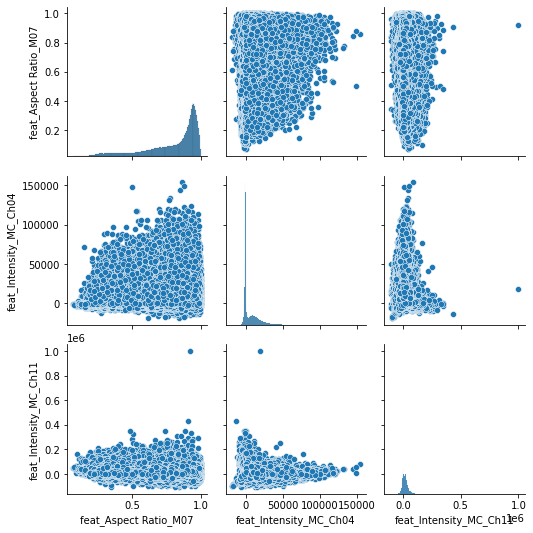

In [8]:
seaborn.pairplot(df[["feat_Aspect Ratio_M07", "feat_Intensity_MC_Ch04", "feat_Intensity_MC_Ch11"]])

## Regression over all cells

<AxesSubplot:xlabel='meta_timepoint', ylabel='feat_Aspect Ratio_M07'>

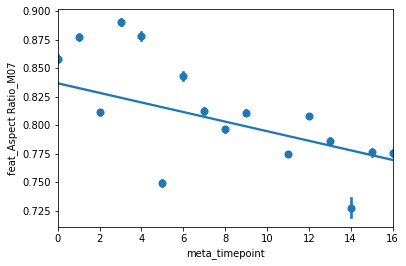

In [9]:
seaborn.regplot(data=df, y="feat_Aspect Ratio_M07", x="meta_timepoint", x_estimator=numpy.mean)

## Regression per population

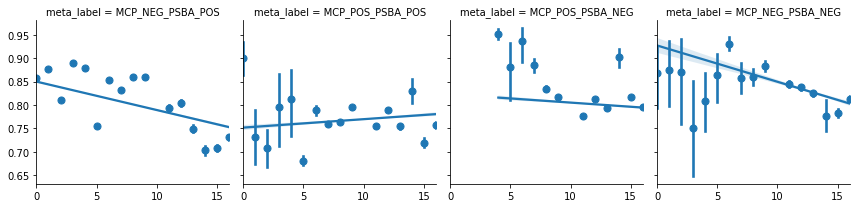

In [13]:
grid = seaborn.FacetGrid(data=df[df["meta_label"] != "unknown"], col="meta_label", col_order=["MCP_NEG_PSBA_POS", "MCP_POS_PSBA_POS", "MCP_POS_PSBA_NEG", "MCP_NEG_PSBA_NEG"])
grid.map_dataframe(seaborn.regplot, y="feat_Aspect Ratio_M07", x="meta_timepoint", x_estimator=numpy.mean)

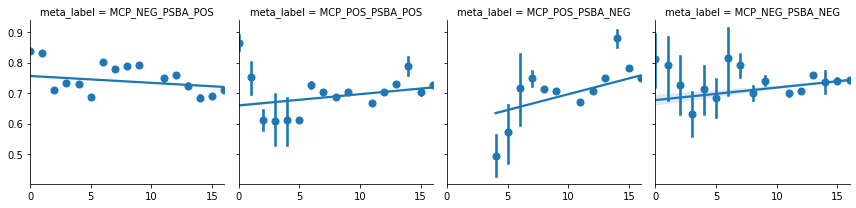

In [15]:
grid = seaborn.FacetGrid(data=df[df["meta_label"] != "unknown"], col="meta_label", col_order=["MCP_NEG_PSBA_POS", "MCP_POS_PSBA_POS", "MCP_POS_PSBA_NEG", "MCP_NEG_PSBA_NEG"])
grid.map_dataframe(seaborn.regplot, y="feat_aspect_ratio_m01", x="meta_timepoint", x_estimator=numpy.mean)

In [35]:
from patsy.contrasts import ContrastMatrix

def _name_levels(prefix, levels):
    return ["[%s%s]" % (prefix, level) for level in levels]

class Simple(object):
    def _simple_contrast(self, levels):
        nlevels = len(levels)
        contr = -1./nlevels * numpy.ones((nlevels, nlevels-1))
        contr[1:][numpy.diag_indices(nlevels-1)] = (nlevels-1.)/nlevels
        return contr

    def code_with_intercept(self, levels):
        contrast = numpy.column_stack((numpy.ones(len(levels)),
                                    self._simple_contrast(levels)))
        return ContrastMatrix(contrast, _name_levels("Simp.", levels))

    def code_without_intercept(self, levels):
        contrast = self._simple_contrast(levels)
        return ContrastMatrix(contrast, _name_levels("Simp.", levels[:-1]))

In [36]:
levels = range(len(df["meta_timepoint"].unique()))
timepoint_contrast = Simple().code_without_intercept(levels)
timepoint_contrast.matrix.shape

(16, 15)

In [37]:
from patsy.contrasts import Diff
levels = range(len(df["meta_replicate"].unique()))
replicate_contrast = Diff().code_without_intercept(levels)
replicate_contrast.matrix

array([[-0.66666667, -0.33333333],
       [ 0.33333333, -0.33333333],
       [ 0.33333333,  0.66666667]])

In [38]:
from patsy.contrasts import Diff
levels = range(len(df["meta_label"].unique()))
label_contrast = Diff().code_without_intercept(levels)
label_contrast.matrix

array([[-0.8, -0.6, -0.4, -0.2],
       [ 0.2, -0.6, -0.4, -0.2],
       [ 0.2,  0.4, -0.4, -0.2],
       [ 0.2,  0.4,  0.6, -0.2],
       [ 0.2,  0.4,  0.6,  0.8]])

In [39]:
import statsmodels.formula.api as smf

In [47]:
res = smf.ols(formula='feat_aspect_ratio_m07 ~ feat_intensity_mc_ch04 + feat_intensity_mc_ch11 + feat_aspect_ratio_m01 + C(meta_timepoint,Simple) + C(meta_replicate,Diff) + C(meta_label, Diff)', data=df).fit()

In [48]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     feat_aspect_ratio_m07   R-squared:                       0.454
Model:                               OLS   Adj. R-squared:                  0.454
Method:                    Least Squares   F-statistic:                 1.014e+04
Date:                   Thu, 04 Mar 2021   Prob (F-statistic):               0.00
Time:                           16:08:22   Log-Likelihood:             1.6050e+05
No. Observations:                 293029   AIC:                        -3.209e+05
Df Residuals:                     293004   BIC:                        -3.207e+05
Df Model:                             24                                         
Covariance Type:               nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   0.4199      0.001    280.649      0.000       0.417       0.423
C(meta_timepoint, Simple)[Simp.0]           0.0046      0.002      2.361      0.018       0.001       0.008
C(meta_timepoint, Simple)[Simp.1]           0.0462      0.002     26.669      0.000       0.043       0.050
C(meta_timepoint, Simple)[Simp.2]           0.0643      0.002     32.161      0.000       0.060       0.068
C(meta_timepoint, Simple)[Simp.3]           0.0417      0.002     19.559      0.000       0.038       0.046
C(meta_timepoint, Simple)[Simp.4]          -0.0363      0.002    -21.263      0.000      -0.040      -0.033
C(meta_timepoint, Simple)[Simp.5]          -0.0185      0.002     -8.645      0.000      -0.023      -0.014
C(meta_timepoint, Simple)[Simp.6]          -0.0271      0.002    -15.263      0.000      -0.031      -0.024
C(meta_timepoint, Simple)[Simp.7]          -0.0253      0.002    -13.589      0.000      -0.029      -0.022
C(meta_timepoint, Simple)[Simp.8]          -0.0204      0.002    -10.584      0.000      -0.024      -0.017
C(meta_timepoint, Simple)[Simp.9]          -0.0532      0.002    -27.068      0.000      -0.057      -0.049
C(meta_timepoint, Simple)[Simp.11]         -0.0454      0.002    -23.099      0.000      -0.049      -0.042
C(meta_timepoint, Simple)[Simp.12]         -0.0840      0.002    -40.118      0.000      -0.088      -0.080
C(meta_timepoint, Simple)[Simp.13]         -0.1271      0.004    -30.048      0.000      -0.135      -0.119
C(meta_timepoint, Simple)[Simp.14]         -0.0972      0.002    -43.504      0.000      -0.102      -0.093
C(meta_timepoint, Simple)[Simp.15]         -0.0936      0.002    -42.961      0.000      -0.098      -0.089
C(meta_replicate, Diff)[D.R1]              -0.0081      0.001    -10.879      0.000      -0.010      -0.007
C(meta_replicate, Diff)[D.R2]               0.0011      0.001      1.850      0.064   -6.79e-05       0.002
C(meta_label, Diff)[D.mcp_neg_psba_neg]     0.0126      0.002      7.518      0.000       0.009       0.016
C(meta_label, Diff)[D.mcp_neg_psba_pos]    -0.0292      0.001    -24.607      0.000      -0.032      -0.027
C(meta_label, Diff)[D.mcp_pos_psba_neg]     0.0159      0.001     17.086      0.000       0.014       0.018
C(meta_label, Diff)[D.mcp_pos_psba_pos]     0.0158      0.005      3.495      0.000       0.007       0.025
feat_intensity_mc_ch04                  -6.997e-07   3.08e-08    -22.744      0.000    -7.6e-07   -6.39e-07
feat_intensity_mc_ch11                  -2.209e-06   1.47e-08   -150.588      0.000   -2.24e-06   -2.18e-06
feat_aspect_ratio_m01                       0.5830      0.001    411.543      0.000       0.580       0.586
==========================

# LASSO regression

In [63]:
from sklearn import linear_model

In [109]:
df_coding = pandas.get_dummies(df.filter(regex="feat|timepoint|label$"), columns=["meta_timepoint"])

In [116]:
results = {}
scores = {}
for idx, gdf in df_coding.groupby("meta_label"):
    downsampled_df = gdf.drop(columns="meta_label")
    model = linear_model.Lasso(fit_intercept=False, alpha=0.5, max_iter=5000)
    res = model.fit(downsampled_df.drop(columns="feat_aspect_ratio_m07"), downsampled_df["feat_aspect_ratio_m07"])
    scores[idx] = res.score(downsampled_df.drop(columns="feat_aspect_ratio_m07"), downsampled_df["feat_aspect_ratio_m07"])
    results[idx] = res

In [117]:
scores

{'mcp_neg_psba_neg': -0.05137217742705702,
 'mcp_neg_psba_pos': 0.4143393989459404,
 'mcp_pos_psba_neg': 0.11360704198313076,
 'mcp_pos_psba_pos': 0.2141561656554759,
 'unknown': 0.06995870079238475}

In [121]:
df_coding.drop(columns=["meta_label", "feat_aspect_ratio_m07"]).columns[results["mcp_neg_psba_pos"].coef_ > 0]

Index(['feat_contrast_m06_ssc', 'feat_gradient_rms_m01_bf',
       'feat_gradient_rms_m09_bf2', 'feat_intensity_mc_ch04',
       'feat_intensity_mc_ssc', 'feat_intensity_mc_ch11',
       'feat_mean_pixel_m07_ch7', 'feat_mean_pixel_m11_ch11',
       'feat_max_pixel_mc_bf', 'feat_max_pixel_mc_ch7',
       'feat_max_pixel_mc_ch11', 'feat_bright_detail_intensity_r3_mc_ch04',
       'feat_bright_detail_intensity_r3_mc_bf2', 'feat_intensity_m02_ch02'],
      dtype='object')

In [122]:
df_coding.drop(columns=["meta_label", "feat_aspect_ratio_m07"]).columns[results["mcp_pos_psba_pos"].coef_ > 0]

Index(['feat_contrast_m03_ch03', 'feat_contrast_m06_ssc',
       'feat_gradient_rms_m01_bf', 'feat_gradient_rms_m09_bf2',
       'feat_intensity_mc_ch04', 'feat_intensity_mc_ssc',
       'feat_intensity_mc_ch11', 'feat_mean_pixel_m07_ch7',
       'feat_max_pixel_mc_ssc', 'feat_max_pixel_mc_ch7',
       'feat_max_pixel_mc_ch11', 'feat_bright_detail_intensity_r3_mc_bf2',
       'feat_intensity_m02_ch02'],
      dtype='object')